In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm


test = pd.read_csv('round1_ijcai_18_test_b_20180418.txt', sep=' ')

train = pd.read_csv('round1_ijcai_18_train_20180301 (1).zip', sep=' ')

sample_sub = pd.read_csv('round1_ijcai_18_result_demo_20180301.txt', sep=' ')

train.nunique()

import time
def preprocess(train):
    def timestamp2datetime(ts):
        dt = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(ts))
        return dt
    train['Timestamp'] = train.context_timestamp.apply(timestamp2datetime)
    train = train.drop(['context_timestamp'], axis=1)
    def time_preprocess(X):
        X['Timestamp'] = pd.to_datetime(X['Timestamp'])
#         X['year'] = X['Timestamp'].dt.year
#         X['month'] = X['Timestamp'].dt.month 
        X['day'] = X['Timestamp'].dt.day
        X['week_day'] = X['Timestamp'].dt.weekday
        X['hour'] = X['Timestamp'].dt.hour
        X['minute'] = X['Timestamp'].dt.minute
        X['minute'] = X['minute'] // 15 * 15
        X = X.drop('Timestamp', axis=1)    
        return X
    train = time_preprocess(train)

    train['item_category_list'] = pd.to_numeric(train.item_category_list.str.split(';', expand=True)[1])

    df = train.item_property_list.str.split(';', expand=True)

    df = df.iloc[:, :21].fillna(-1).apply(pd.to_numeric)
    train = pd.concat([train, df], axis=1).reset_index(drop=True).drop('item_property_list', axis=1)

    train['predict_category_property'] = train.predict_category_property.str.split(';',
                                                                                   expand=True).isnull().sum(axis=1)
    train.columns = list(map(str, train.columns.tolist()))

    return train
train = preprocess(train)
test = preprocess(test)

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train)
rejected_variables = profile.get_rejected_variables(threshold=0.9)
rejected_variables

In [37]:
# X_train = pd.concat([test, train.drop('is_trade', axis=1)], ignore_index=True).reset_index(drop=True)
X_train = train.copy()

In [38]:
import gc

aggs = ['count', 'var', 'mean', 'nunique', 'cumcount']
cols2select = ["item_sales_level", 'item_price_level', 'item_price_level', 'item_pv_level', 'hour', 'minute',
               'shop_score_service']
arr2group = [['user_id'], ['user_id', 'context_id']]

GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
#     {'groupby': ['user_id'], 'select': 'item_price_level', 'agg': 'count'}
]
for arr in arr2group:
    for col in cols2select:
        for agg in aggs:
            GROUPBY_AGGREGATIONS.append({'groupby': arr, 'select': col, 'agg': agg})


for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

Grouping by ['user_id'], and aggregating item_sales_level with count
Grouping by ['user_id'], and aggregating item_sales_level with var
Grouping by ['user_id'], and aggregating item_sales_level with mean
Grouping by ['user_id'], and aggregating item_sales_level with nunique
Grouping by ['user_id'], and aggregating item_sales_level with cumcount
Grouping by ['user_id'], and aggregating item_price_level with count
Grouping by ['user_id'], and aggregating item_price_level with var
Grouping by ['user_id'], and aggregating item_price_level with mean
Grouping by ['user_id'], and aggregating item_price_level with nunique
Grouping by ['user_id'], and aggregating item_price_level with cumcount
Grouping by ['user_id'], and aggregating item_price_level with count
Grouping by ['user_id'], and aggregating item_price_level with var
Grouping by ['user_id'], and aggregating item_price_level with mean
Grouping by ['user_id'], and aggregating item_price_level with nunique
Grouping by ['user_id'], and ag

Use token 1260389131217015787.
/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer
[LightGBM] [Info] Number of positive: 7211, number of negative: 375299
[LightGBM] [Info] Total Bins 11531
[LightGBM] [Info] Number of data: 382510, number of used features: 100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.605155
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.533177
[3]	valid_0's binary_logloss: 0.473255
[4]	valid_0's binary_logloss: 0.422766
[5]	valid_0's binary_logloss: 0.379819
[6]	valid_0's binary_logloss: 0.342975
[7]	valid_0's binary_logloss: 0.31118
[8]	valid_0's binary_logloss: 0.324912
[9]	valid_0's binary_logloss: 0.295552
[10]	valid_0's binary_logloss: 0.270069
[11]	valid_0's binary_logloss: 0.247831
[12]	valid_0's binary_logloss: 0.256222
[13]	valid_0's binary_logloss: 0.235701
[14]	valid_0's binary_logloss: 0.217744
[15]	valid_0's binary_logloss: 0.202029
[16]	valid

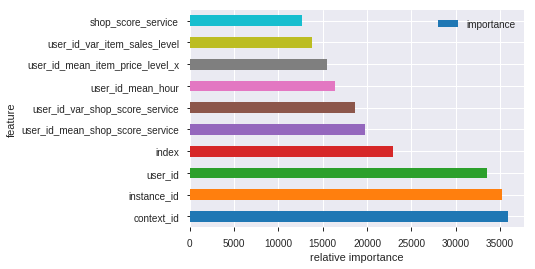

In [43]:
from sklearn.model_selection import train_test_split
to_drop = ['index','instance_id']
# to_drop = []
x_train, x_test, y_train, y_test = train_test_split(
    X_train.drop(['is_trade'] + to_drop + rejected_variables, axis=1).values, X_train['is_trade'].values,
    test_size=0.2)

from sklearn.metrics import log_loss
import lightgbm as lgb
import telepyth # push notif in telegram
%telepyth -t 1260389131217015787
%load_ext wurlitzer
verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
#     "learning_rate": 0.01,
    "boosting_type": "dart",
    "objective": "binary",
    'num_iterations':1200,
    "metric": "binary",
    "num_leaves": 2**12,
    "verbose": 1,
    "min_data_in_leaf": 40,
#     "boost_from_average": True
    'early_stopping_round': 150,
    'bagging_fraction':0.7

}

d_train = lgb.Dataset(x_train, y_train)
d_valid = lgb.Dataset(x_test, label=y_test)
model = lgb.train(params, d_train, valid_sets=d_valid)

df_fi = pd.DataFrame(X_train.drop(['is_trade'] + to_drop + rejected_variables, axis=1).columns, columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
#     plt.title('Roc_auc is {}'.format(roc_auc_score(y_test, y_pred)))
    plt.xlabel('relative importance')
    plt.show()

In [44]:
y_pred = model.predict(test.drop(rejected_variables, axis=1))

In [45]:
sub = pd.DataFrame(test.instance_id, columns=['instance_id'])
sub['predicted_score'] = y_pred
sub.to_csv('sub.txt', sep=' ', index=False)